<a href="https://colab.research.google.com/github/jpdeleon/chronos/blob/master/notebooks/examples-lightcurves-tess-pathos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install git+https://github.com/jpdeleon/chronos.git@master

In [2]:
%matplotlib inline
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [26]:
p = cr.PATHOS(ticid=159059181, lctype="corr", aper_idx=4)

Target: TIC 159059181
Using PATHOS lightcurve.
Available sectors: [6]
Using sector=6.
Querying Gaia DR2 catalog for ra,dec=(88.3712 0.42402) within 3.0 arcsec.
Querying TIC catalog for ra,dec=(88.3712 0.42402) within 3.0 arcsec.
Gaia and TIC catalog cross-match succeeded.
Found 1 PATHOS lightcurves.
Filename: /home/jp/.astropy/cache/download/py3/e3b674a47b48df2bb301dc02b5f695b6
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     55   993R x 16C   [D, E, D, D, D, D, D, D, D, D, D, D, D, D, D, I]   
None


In [27]:
df = p.get_pathos_candidates()
df.head()

,TIC_ID,PATHOS_ID,Cluster,RA (deg),Dec. (deg),Period (day),T0 (BTJD),Rp/R*,Note,Tmag,...,gof_al,excess_noise_sig,Sectors,duration,T_14,T_14(15p),T_14(84p),parallax,pmra,pmdec
0,394126269,1,Galactic Field,2.8796,-70.9869,3.8582,1339.677,0.152,NaN,15.3310,...,-0.354171,0.000000,[1],0.091467,NaN,NaN,NaN,0.93,-5.36,-7.40
1,30654608,2,Muzzio 1,134.3845,-47.8477,2.4955,1519.662,0.048,NaN,10.5145,...,7.567358,0.000000,[8 9],0.035755,0.120276,NaN,NaN,0.52,-5.07,4.21
2,39291805,3,NGC 2112,88.7164,-0.0484,7.1719,1469.033,0.190,NaN,15.2969,...,0.145179,0.614887,[6],NaN,0.153509,-0.015647,0.024105,0.90,-3.44,4.33
3,42524156,4,ASCC 88,256.8882,-35.5036,10.0130,1631.474,0.125,NaN,10.6032,...,15.534905,0.316368,[12],0.148971,0.168851,-0.021037,0.039205,1.15,1.09,-3.18
4,80317933,5,Collinder 292,237.9156,-57.2797,3.2098,1625.529,0.232,NaN,13.0067,...,-2.623820,0.000000,[12],0.169752,0.191158,-0.015335,0.019807,0.63,-2.40,-2.41


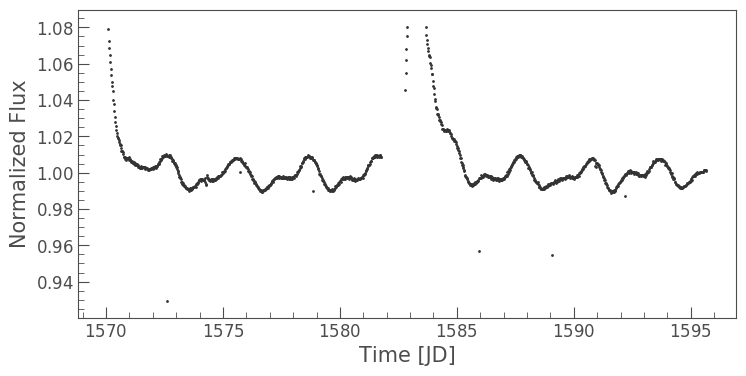

In [27]:
lc = p.lc.remove_outliers(sigma_lower=5)
lc.scatter()

Using period=8.3227 d, epoch=2458599.25 BTJD, duration=1.78 hr
Using biweight filter with window_length=0.22 day


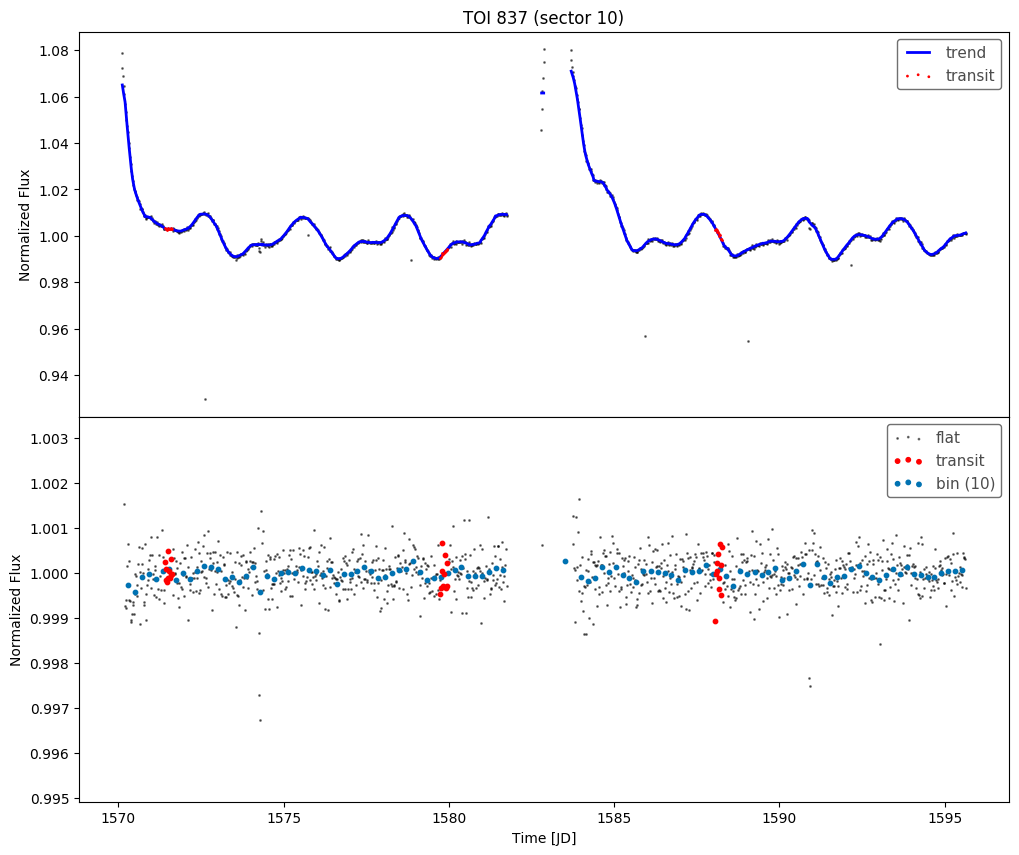

In [28]:
fig = p.plot_trend_flat_lcs(lc,
                            period=p.toi_period,
                            epoch=p.toi_epoch,
                            duration=p.toi_duration
                           )

Using biweight filter with window_length=0.22 day


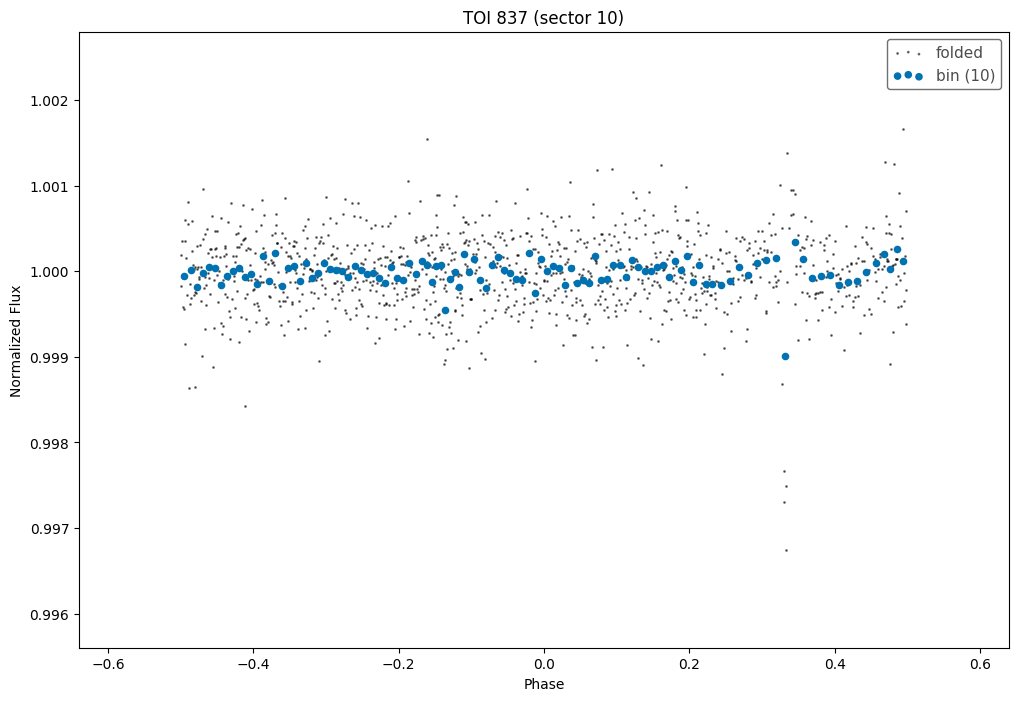

In [29]:
flat = p.get_flat_lc(lc,
                     period=p.toi_period,
                    epoch=p.toi_epoch,
                    duration=p.toi_duration
                    )
fig = p.plot_fold_lc(flat,
                     period=p.toi_period,
                    epoch=p.toi_epoch,
                    duration=p.toi_duration
                    )

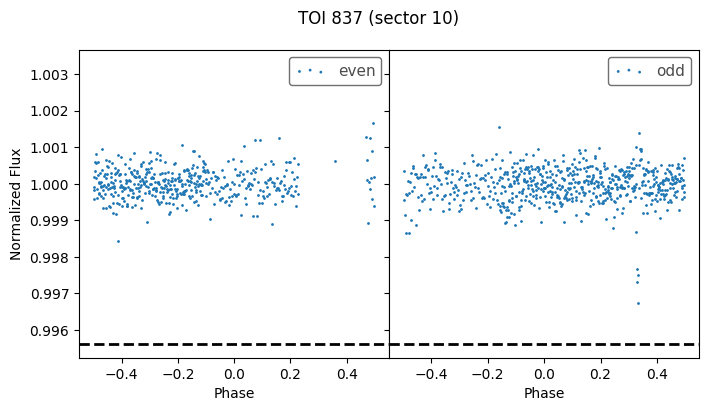

In [30]:
fig = p.plot_odd_even(flat,
                period=p.toi_period,
                    epoch=p.toi_epoch,
               )

## add gof and D

In [9]:
from tqdm import tqdm

tmags = {}
sectors = {}
gaia_params = {}
for idx,row in tqdm(df.iterrows()):
    ticid = row['TIC_ID']
    t = cr.Target(ticid=ticid, verbose=False)
    sectors[ticid] = t.all_sectors
    #tic
    tic_params = t.query_tic_catalog(return_nearest_xmatch=True)
    tmags[ticid] = tic_params.Tmag
    #gaia
    g = t.query_gaia_dr2_catalog(return_nearest_xmatch=True)
    gaia_params[ticid] = g

1it [00:07,  7.81s/it]

There are 2 TIC stars within 3.0 arcsec


2it [00:13,  7.32s/it]

There are 2 gaia sources within 3.0 arcsec.
There are 2 TIC stars within 3.0 arcsec


3it [00:23,  7.92s/it]

There are 2 gaia sources within 3.0 arcsec.


4it [00:35,  9.20s/it]

There are 3 TIC stars within 3.0 arcsec


5it [00:41,  8.34s/it]

There are 3 gaia sources within 3.0 arcsec.


14it [01:36,  5.98s/it]

astrometric_gof_al>20.44 (>20 hints binarity).
See https://arxiv.org/pdf/1804.11082.pdf



16it [01:49,  6.11s/it]

There are 2 TIC stars within 3.0 arcsec


17it [01:55,  6.00s/it]

There are 2 gaia sources within 3.0 arcsec.


18it [02:02,  6.30s/it]

There are 2 TIC stars within 3.0 arcsec


19it [02:08,  6.19s/it]

There are 2 gaia sources within 3.0 arcsec.


21it [02:21,  6.61s/it]

white dwarf flag = True!


23it [02:33,  6.12s/it]

astrometric_excess_noise_sig>8.65 (>5 hints binarity).

astrometric_gof_al>20.22 (>20 hints binarity).
See https://arxiv.org/pdf/1804.11082.pdf



29it [03:10,  6.23s/it]

There are 2 TIC stars within 3.0 arcsec


30it [03:15,  5.89s/it]

There are 2 gaia sources within 3.0 arcsec.


32it [03:26,  5.73s/it]

There are 3 TIC stars within 3.0 arcsec


33it [03:32,  5.95s/it]

There are 2 gaia sources within 3.0 arcsec.
astrometric_excess_noise_sig>37.16 (>5 hints binarity).

astrometric_gof_al>21.39 (>20 hints binarity).
See https://arxiv.org/pdf/1804.11082.pdf

There are 2 TIC stars within 3.0 arcsec


34it [03:39,  6.05s/it]

There are 2 gaia sources within 3.0 arcsec.


In [11]:
gaia_params[ticid].astrometric_gof_al, gaia_params[ticid].astrometric_excess_noise_sig

(1.85851657, 0.0)

In [21]:
mags = {ticid: tmags[ticid] for ticid in tmags}
secs = {ticid: sectors[ticid] for ticid in sectors}
pars = {ticid: gaia_params[ticid].parallax for ticid in gaia_params}
pmras = {ticid: gaia_params[ticid].pmra for ticid in gaia_params}
pmdecs = {ticid: gaia_params[ticid].pmdec for ticid in gaia_params}
gmags = {ticid: gaia_params[ticid].phot_g_mean_mag for ticid in gaia_params}
gof_al = {ticid: gaia_params[ticid].astrometric_gof_al for ticid in gaia_params}
excess_noise_sig = {ticid: gaia_params[ticid].astrometric_excess_noise_sig for ticid in gaia_params}

In [22]:
import pandas as pd

d = pd.DataFrame([gof_al,excess_noise_sig,mags,secs,gmags,pars,pmras,pmdecs]).T
d = d.reset_index()
d.columns = ['TIC_ID','gof_al','excess_noise_sig', 'Tmag', 'Sectors', 'Gmag', 'Parallax', 'pmra', 'pmdec']

pathos_candidates = pd.merge(left=df,right=d,on='TIC_ID')

In [23]:
pathos_candidates

,TIC_ID,PATHOS_ID,Cluster,RA (deg),Dec. (deg),Period (day),T0 (BTJD),Rp/R*,Note,Tmag_x,...,T_14(15p),T_14(84p),gof_al_y,excess_noise_sig_y,Tmag_y,Sectors_y,Gmag_y,Parallax,pmra,pmdec
0,394126269,1,Galactic Field,2.8796,-70.9869,3.8582,1339.677,0.152,NaN,15.3310,...,NaN,NaN,-0.354171,0,15.331,[1],15.9134,0.930813,-5.36418,-7.39884
1,30654608,2,Muzzio 1,134.3845,-47.8477,2.4955,1519.662,0.048,NaN,10.5145,...,NaN,NaN,7.56736,0,10.5145,"[8, 9]",11.2327,0.519071,-5.06565,4.20787
2,39291805,3,NGC 2112,88.7164,-0.0484,7.1719,1469.033,0.190,NaN,15.2969,...,-0.015647,0.024105,0.145179,0.614887,15.2969,[6],16.0683,0.896388,-3.44274,4.32809
3,42524156,4,ASCC 88,256.8882,-35.5036,10.0130,1631.474,0.125,NaN,10.6032,...,-0.021037,0.039205,15.5349,0.316368,10.6032,[12],10.9042,1.15019,1.08927,-3.18239
4,80317933,5,Collinder 292,237.9156,-57.2797,3.2098,1625.529,0.232,NaN,13.0067,...,-0.015335,0.019807,-2.62382,0,13.0067,[12],13.3413,0.632027,-2.40453,-2.40532
5,88977253,6,NGC 2548,123.0977,-5.7687,2.7677,1492.708,0.146,TOI-496,12.3300,...,-0.012585,0.031350,6.37556,0,12.33,[7],12.6242,1.23575,-1.07602,0.830496
6,92835691,7,SAI 91,129.1193,-50.1497,22.3661,1527.825,0.214,NaN,14.6866,...,-0.033460,0.054570,-2.7192,0,14.6866,"[8, 9]",15.2706,0.234704,-3.21684,3.86755
7,94589619,8,NGC 2437,115.7338,-14.5810,12.0829,1496.198,0.187,NaN,13.8554,...,-0.021009,0.043604,-1.8491,0,13.8554,[7],14.1439,0.623813,-4.05192,0.379285
8,125414447,9,NGC 2323,105.7303,-8.4369,3.7069,1493.200,0.229,NaN,14.2935,...,-0.004299,0.005620,-3.35929,0,14.2935,[7],14.8036,0.931989,0.0028475,-0.654296
9,126600730,10,Haffner 14,116.0772,-28.3253,6.2991,1497.305,0.102,NaN,15.4686,...,NaN,NaN,-1.46309,1.21857e-15,15.4686,[7],15.9648,0.214472,-2.01346,1.19975


In [24]:
# idx = p.pathos_candidates['Dec. (deg)']>-30
pathos_candidates.to_csv("../chronos/data/pathos_candidates.csv", index=False)

## See also
* examples-lightcurves-tess-cdips.ipynb

In [ ]:
fig = p.plot_trend_flat_lcs(lc,
                            period=p.toi_period,
                            epoch=p.toi_epoch,
                            duration=p.toi_duration
                           )